## Overview

It is a follow-up notebook to "Fine-tuning ResNet34 on ship detection" (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection/notebook) and "Unet34 (dice 0.87+)" (https://www.kaggle.com/iafoss/unet34-dice-0-87/notebook) that shows how to evaluate the solution and submit predictions. Please check these notebooks for additional details.

In [1]:
                                                                                                                from fastai.conv_learner import *
from fastai.dataset import *
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from scipy import ndimage

/home/damminhtien/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = './'
TRAIN = './input/train/'
TEST = './input/test/'
SEGMENTATION = './input/train_ship_segmentations.csv'
PRETRAINED_DETECTION_PATH = './input/models/'
PRETRAINED_SEGMENTATION_PATH = './unet34/'
DETECTION_TEST_PRED = './input/ship_detection.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

In [3]:
# import torchvision.models as models
# resnet34 = models.resnet34()
nw = 2   # number of workers for data loader
arch = resnet34 # specify target architecture

### Data

In [4]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

As explained in https://www.kaggle.com/iafoss/unet34-dice-0-87/notebook, I drop all images without ships. The model responsible for ship detection will take care of them.

In [5]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n_cut = cut_empty(tr_n)
val_n_cut = cut_empty(val_n)

In [6]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

In [8]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
    tr_names = tr_n if (len(tr_n_cut)%bs == 0) else tr_n[:-(len(tr_n_cut)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n_cut,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
#     md.is_multi = False
    return md

### Model

In [9]:
cut,lr_cut = model_meta[arch]

In [10]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

In [11]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

### Score evaluation

In [12]:
def IoU(pred, targs):
    pred = (pred > 0.5).astype(float)
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [13]:
def get_score(pred, true):
    n_th = 10
    b = 4
    thresholds = [0.5 + 0.05*i for i in range(n_th)]
    n_masks = len(true)
    n_pred = len(pred)
    ious = []
    score = 0
    for mask in true:
        buf = []
        for p in pred: buf.append(IoU(p,mask))
        ious.append(buf)
    for t in thresholds:   
        tp, fp, fn = 0, 0, 0
        for i in range(n_masks):
            match = False
            for j in range(n_pred):
                if ious[i][j] > t: match = True
            if not match: fn += 1
        
        for j in range(n_pred):
            match = False
            for i in range(n_masks):
                if ious[i][j] > t: match = True
            if match: tp += 1
            else: fp += 1
        score += ((b+1)*tp)/((b+1)*tp + b*fn + fp)       
    return score/n_th

In this competition we should submit and individual mask for each identified ship. The simplest way to do it is splitting the total mask into individual ones based on the connectivity of detected objects.

In [14]:
def split_mask(mask):
    threshold = 0.5
    threshold_obj = 30 #ignor predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

In [15]:
def get_mask_ind(img_id, df, shape = (768,768)): #return mask for each ship
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return []
    if(type(masks) == str): masks = [masks]
    result = []
    for mask in masks:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
        result.append(img.reshape(shape).T)
    return result

In [16]:
class Score_eval():
    def __init__(self):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        self.score, self.count = 0.0, 0
        
    def put(self,pred,name):
        true = get_mask_ind(name, self.segmentation_df)
        self.score += get_score(pred,true)
        self.count += 1
        
    def evaluate(self):
        return self.score/self.count

### Prediction

In [17]:
m = to_gpu(Unet34(get_base()))
models = UnetModel(m)

In [18]:
sz = 768 #image size
bs = 8  #batch size
md = get_data(sz,bs)

In [19]:
learn = ConvLearner(md, models)
learn.models_path = PRETRAINED_SEGMENTATION_PATH
learn.load('Unet34_768_1')
learn.models_path = PATH

Since the model predicts pixel masks, which are quite large, running standard functions for making a prediction will fail due to memory issue, especially for the test set, where about 100k 786x786 pixel masks should be created. Therefore, I wrote a function that does prediction batch by batch and applies F_save function for each generated mask.

In [20]:
def model_pred(learner, dl, F_save): #if use train dl, disable shuffling
    learner.model.eval();
    name_list = dl.dataset.fnames
    num_batchs = len(dl)
    t = tqdm(iter(dl), leave=False, total=num_batchs)
    count = 0
    for x,y in t:
        py = to_np(F.sigmoid(learn.model(V(x))))
        batch_size = len(py)
        for i in range(batch_size):
            F_save(py[i],to_np(y[i]),name_list[count])
            count += 1

Running the model evaluation on the validation set.

In [21]:
score = Score_eval()
process_pred = lambda yp, y, name : score.put(split_mask(yp),name)
model_pred(learn, md.val_dl, process_pred)
print('\n',score.evaluate())

                                              
 0.24586679130742775


It is the **score based only on images with ships**, a model responsible for ship detection (accuracy ~98%) takes care of images without ships. Since the fraction of empty images in the test set is ~0.85, the expected score of the model stacked with ship detection one (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection/notebook) is approximately 0.85 + 0.35 * 0.15 = 0.90. However, you should keep in mind that the evaluated model has been trained only for one epoch on full resolution images (the dice is only ~0.80 for 784x784 images). I tried to do similar testing for a model with dice 0.895 and got 0.44 based on images only with ships that would result in 0.92 for the model evaluation score. Continuing training the model, TTA, and mask postprocessing can further boost it.

### Submission

Load the prediction of ship detection model (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection/notebook) for the test set.

In [22]:
ship_detection = pd.read_csv(DETECTION_TEST_PRED)
ship_detection.head()

,id,p_ship
0,0a08b786b.jpg,0.001433
1,84f0697a1.jpg,0.001666
2,f1df2b6e3.jpg,0.000293
3,03a5fd8d2.jpg,0.998661
4,6780b04e2.jpg,0.000014


Identify images with ships and run Unet34 model only for them (~15%).

In [23]:
test_names = ship_detection.loc[ship_detection['p_ship'] > 0.5, ['id']]['id'].values.tolist()
test_names_nothing = ship_detection.loc[ship_detection['p_ship'] <= 0.5, ['id']]['id'].values.tolist()
len(test_names), len(test_names_nothing)

(14668, 73818)

In [24]:
md = get_data(sz,bs)
learn.set_data(md)

The function for mask decoding is borrowed from https://www.kaggle.com/kmader/from-trained-u-net-to-submission-part-2/notebook .

In [25]:
def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
ship_list_dict = []
for name in test_names_nothing:
    ship_list_dict.append({'ImageId':name,'EncodedPixels':np.nan})

In [27]:
def enc_test(yp, y, name):
    masks = split_mask(yp)
    if(len(masks) == 0): 
        ship_list_dict.append({'ImageId':name,'EncodedPixels':np.nan})
    for mask in masks:
        ship_list_dict.append({'ImageId':name,'EncodedPixels':decode_mask(mask)})

In [28]:
def Show_images(x,yp,yt):
    columns = 3
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.axis('off')
        plt.imshow(x[i])
        fig.add_subplot(rows, columns, 3*i+2)
        plt.axis('off')
        plt.imshow(yp[i])
        fig.add_subplot(rows, columns, 3*i+3)
        plt.axis('off')
        plt.imshow(yt[i])
    plt.show()

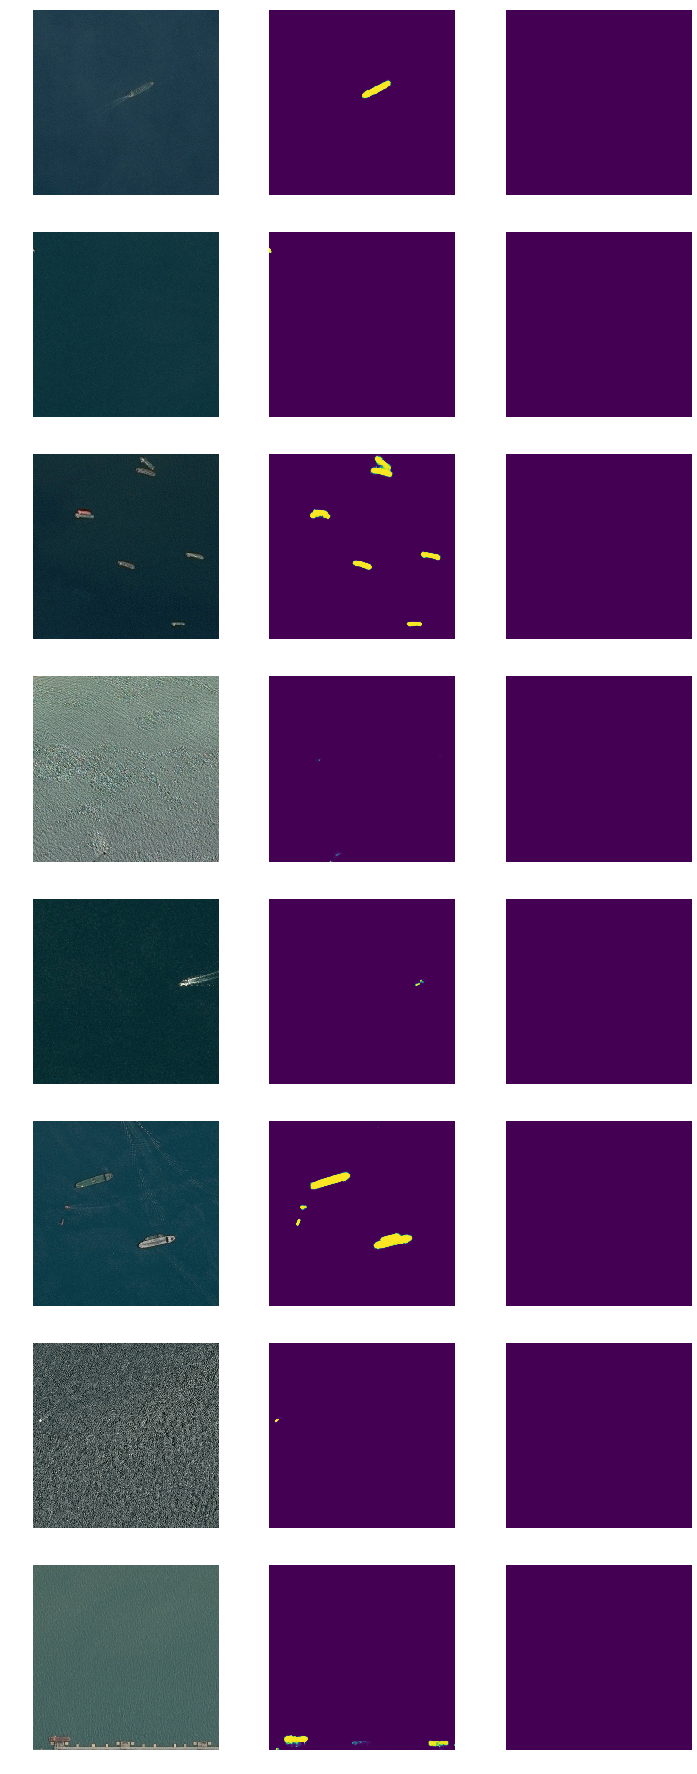

In [29]:
x,y = next(iter(md.val_dl))
yp = to_np(F.sigmoid(learn.model(V(x))))
Show_images(np.asarray(md.val_ds.denorm(x)), yp, y)

In [30]:
def crop_black_background(image):
    """
    :param image:
    :return:
    rotatedImage: real image after rotate straight
    angle: angle to rotate image straight
    M_back: matrix to rotate straight image to original image
    pts: bounding box of real straight image
    """

    # Convert image->grayscale->threshold->binary->find contour
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image_grayscale, 1, 255, cv2.THRESH_BINARY)

    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find max contour
    maxContourArea = 0
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        width = min(rect[1][0], rect[1][1])
        height = max(rect[1][0], rect[1][1])
        area = width * height
        if area > maxContourArea:
            maxContourArea = area
            maxRect = rect
            maxCnt = cnt

    # Find rectangle bouding contour -> real image
    epsilon = 0.1 * cv2.arcLength(maxCnt, True)
    approx = cv2.approxPolyDP(maxCnt, epsilon, True)

    box = np.zeros((4, 2), dtype=np.int32)

    # Find angle that real image rotated
    angle = maxRect[2]
    if angle < -45:
        angle += 90

    # Assign approx to box to guarantee that box points arrange through counter-clockwise from top
    if angle > 0:
        box[0] = approx[0][0]
        box[1] = approx[1][0]
        box[2] = approx[2][0]
        box[3] = approx[3][0]
    else:
        box[0] = approx[1][0]
        box[1] = approx[2][0]
        box[2] = approx[3][0]
        box[3] = approx[0][0]

    #find bouding coordinates of box
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    # Determine h, w and center of bounding of box
    (h, w) = (x2 - x1, y2 - y1)
    (cX, cY) = (w // 2, h // 2)

    # M: matrix rotation that rotate real image to traight
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    nW2 = nH if nH > nW else nW
    nH2 = nH if nH < nW else nW

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # rotate real image to straight
    croppedRotated = cv2.warpAffine(image, M, (nW2, nH2))
    pts = np.int0(cv2.transform(np.array([box]), M))[0]
    pts[pts < 0] = 0

    # M_back: matrix rotate image from straight to original
    M_back = cv2.getRotationMatrix2D((cY, cX), -angle, 1.0)

    # Determine bounding coordinate of straight image
    Xs = [i[0] for i in pts]
    Ys = [i[1] for i in pts]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    # Crop to get real straight image
    croppedRotated = croppedRotated[y1:y2, x1:x2]

    return croppedRotated, angle, M_back, pts

In [31]:
import cv2
im = cv2.imread('./input/20171218_024716_1036_3B_Visual_crop2.tif', 1)
croppedRotated, angle, M_back, pts = crop_black_background(im)
cv2.imwrite('./input/20171218_024716_1036_3B_Visual.png', croppedRotated)

True

In [32]:
def Show_image(x,yp,yt):
    columns = 2
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    plt.imshow(x[0])
    fig.add_subplot(rows, columns, 2)
    plt.axis('off')
    plt.imshow(yp[0])
    cv2.imwrite('input.png', x[0]*255)
    cv2.imwrite('output.png', yp[0]*255)
    plt.show()

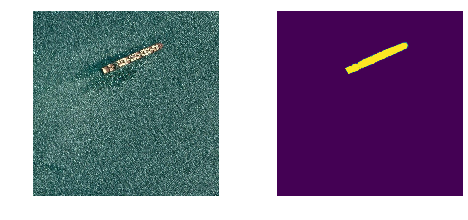

In [37]:
fn = './00ce2c1c0.jpg'
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)
x,y = next(iter(dl))
yp = to_np(F.sigmoid(learn.model(V(x))))
Show_image(np.asarray(md.val_ds.denorm(x)), yp, y)